In [1]:
import os                                               #os interface library 
import requests                                         #HTTP requests library
import pandas as pd                                     #panda library
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api
import alpaca_trade_api as trade_api                    #Alpaca library
from alpaca_trade_api.rest import REST, TimeFrame
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
import json                                             #JSON library ro work with JSON objects
from datetime import date                               #Data-Time library
import yfinance as yf
#set the backend of matplotlib to the 'inline' backend 
%matplotlib inline 
# Load .env enviroment variables
import numpy as np
#function for the keys to gain access to data:
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')
    return alpaca
    

In [2]:
load_dotenv()

True

In [3]:
# # Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                        
    today = pd.Timestamp(today, tz="America/New_York").isoformat()  
    timeframe ='1Day'
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df
    portfolio.index = portfolio.index.date
    return portfolio
# function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)
    symbol = bench_mark[['close']].rename(columns ={'close': symbol})
    return symbol
#function to retrive data for 3 -Month Treasury Note Bill:
def riskf_r():
    today = date.today() + pd.DateOffset(years=-5)
    rf_rate = yf.download('^IRX',start = today)
    rf_rate = rf_rate[['Close']]
    rf_rate = rf_rate.rename(columns = {'Close' : 'rf_rate'})
    rf_returns = rf_rate.pct_change()
    rf_returns = rf_returns.dropna()
    return rf_returns
                
    
# function to prepare the required data of the tickers :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)
    closing_price = ticker[['close']]
    closing_price = closing_price.rename(columns={'close' : 'close'})
    return closing_price
# function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()
    data_cumulative = (1+data_returns).cumprod()
    return data_cumulative
# function for equally weighting stocks to make the portfolio:
def equal_weights(data):
    weights = []
    for i in range(0,len(portfolio.columns)):
        w = 1/len(portfolio.columns)
        weights.append(w)
    return weights   
# function for varrying weights and to return the top 5 returns with associated weights:
def combination_weights(data,initial_investment):
    from itertools import combinations
    import numpy as np
    df = []
    a = list(np.arange(0.05,1,0.01))
    random_set = [round(i,3) for i in a]
    
    comb = combinations(random_set,len(data.columns))
    possible_combinations = []
    # for loop for appropriate weights :
    for i in comb:
        if sum(i) == 1:
            possible_combinations.append(i)
    daily_returns = data.pct_change().dropna()
    for i in possible_combinations:
        possible_returns = daily_returns.dot(i)
        cumulative_final_return = (1+possible_returns).cumprod()
        final_day_value = cumulative_final_return.iloc[-1]
        final_return = final_day_value*initial_investment
        df.append((final_return,i))
    data_frame = pd.DataFrame(df)
    best_combination = data_frame.rename(columns={0:'Return',1:'Weights'})
    top_5 = best_combination.nlargest(5,'Return')
    
    return top_5
# function for sharpe ratios of the top 5 returns to choose the portfolio according the risk appetite of investor:
def sharpe_ratios(a):
    best_weights = a['Weights']
    cumulative_weighted_portfolios = []
    for i in best_weights:
        weighted_price_action = portfolio_cumulative.dot(i)
        cumulative_weighted_portfolios.append(weighted_price_action)
        c_w_p = pd.DataFrame(cumulative_weighted_portfolios)
    c_w_p = c_w_p.T
    c_w_p = c_w_p.rename(columns ={0 :'w1',1:'w2',2:'w3',3:'w4',4:'w5'})
    c_w_returns = c_w_p.pct_change()
    c_w_r =c_w_returns.dropna()
    assembled_returns = pd.concat([c_w_r,r_rate],axis =1 ,join ='inner')
    s_r = ((assembled_returns.mean()-assembled_returns['rf_rate'].mean())*(252))/(assembled_returns.std()*np.sqrt(252))
    sharpe_ratio = pd.Series(s_r)
    sharpe_ratio = sharpe_ratio.drop('rf_rate')
    a['sharpe_ratio'] = sharpe_ratio.values
    return a
# function for comparing returns and risk taken for those returns with the benchmark :
def spy_comaprison(x):
    x = spy
    x_returns = x.pct_change()
    x_returns = x_returns.dropna()
    x_final_value = spy_cumulative*1000
    x_final_value=list(x_final_value.iloc[-1])
    x_sharpe = pd.concat([x_returns,r_rate],axis = 1,join ='inner')
    x_sharpe_ratio = ((x_sharpe.mean()-x_sharpe['rf_rate'].mean())*252)/(x_sharpe.std()*np.sqrt(252))
    x_sharpe_ratio =pd.Series(x_sharpe_ratio)
    x_sharpe_ratio = x_sharpe_ratio['SPY']
    sharpe_ratio.loc['SPY'] = [x_final_value[0],((1)),x_sharpe_ratio]
    percent_return = []
    for i in sharpe_ratio['Return']:
        initial_investment = 1000
        per_return = ((i - initial_investment)/initial_investment)*100
        percent_return.append(per_return)
    sharpe_ratio['%_return'] = percent_return
    return sharpe_ratio



In [4]:
# Setting th api and retrieving data
alpaca = setting_api()
tickers = ['APD', 'FLEX', 'PPG', 'TEL', 'IFF', 'GLW']
portfolio = portfolio_data(tickers)
portfolio.head()


,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-20,135.62,137.34,135.200,136.90,985329,10779,136.676759,APD
2017-04-21,136.87,137.66,136.820,137.30,1121329,9645,137.275887,APD
2017-04-24,138.79,139.90,137.910,139.76,1006799,11797,139.453526,APD
2017-04-25,140.22,141.86,140.140,141.73,1189378,12897,141.327276,APD
2017-04-26,141.41,142.45,140.751,141.58,1512250,15690,142.006437,APD


In [5]:
# preparing data :
apd =format_data('APD')
flx =format_data('FLEX')
ppg=format_data('PPG')
tel=format_data('TEL')
iff=format_data('IFF')
glw=format_data('GLW')
apd.head()

,close
2017-04-20,136.90
2017-04-21,137.30
2017-04-24,139.76
2017-04-25,141.73
2017-04-26,141.58


In [6]:
portfolio = pd.concat([apd,flx,ppg,tel,iff,glw],axis =1,keys = ['APD','FLEX','PPG','TEL','IFF','GLW'])
portfolio.head()

,APD,FLEX,PPG,TEL,IFF,GLW
,close,close,close,close,close,close
2017-04-20,136.90,15.97,106.37,74.12,135.80,27.11
2017-04-21,137.30,15.97,105.94,73.61,136.12,27.02
2017-04-24,139.76,16.10,108.01,75.21,138.03,27.52
2017-04-25,141.73,16.26,110.82,75.60,139.09,28.54
2017-04-26,141.58,16.07,110.48,76.65,138.80,28.39


In [7]:
# Setting the bench- mark for comparison with portfolio :
spy = bench_mark('SPY')

In [8]:
# Retrieving data of interest rates to calculate sharpe ratios:
r_rate = riskf_r()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

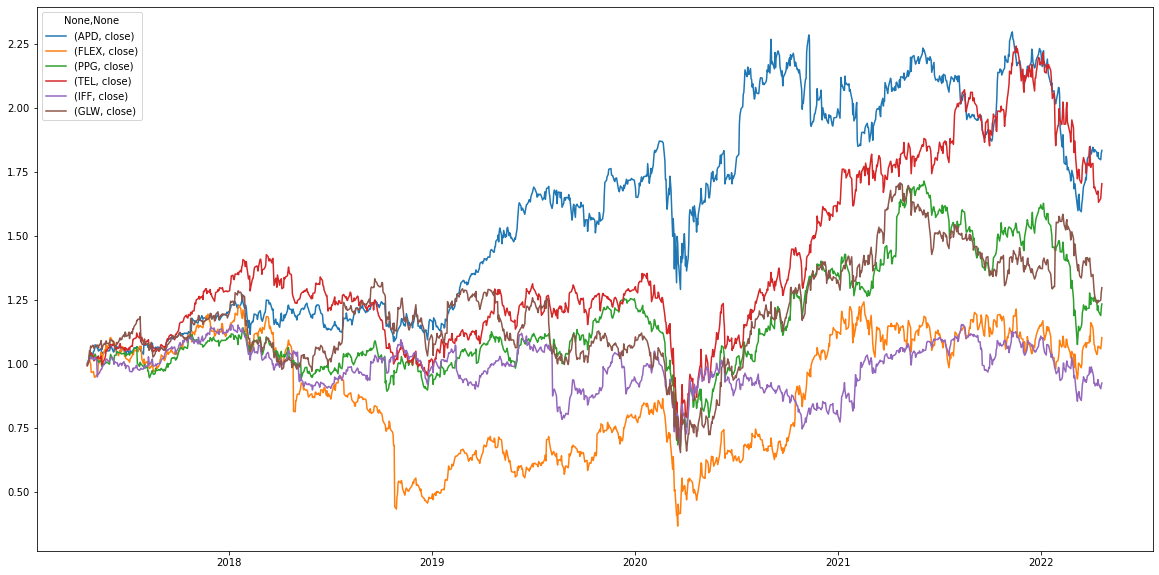

In [9]:
# Visually analyzing the performance of individual stocks:
spy_cumulative = cumulative_returns(spy)
portfolio_cumulative = cumulative_returns(portfolio)
portfolio_cumulative.plot(figsize = (20,10))

<AxesSubplot:>

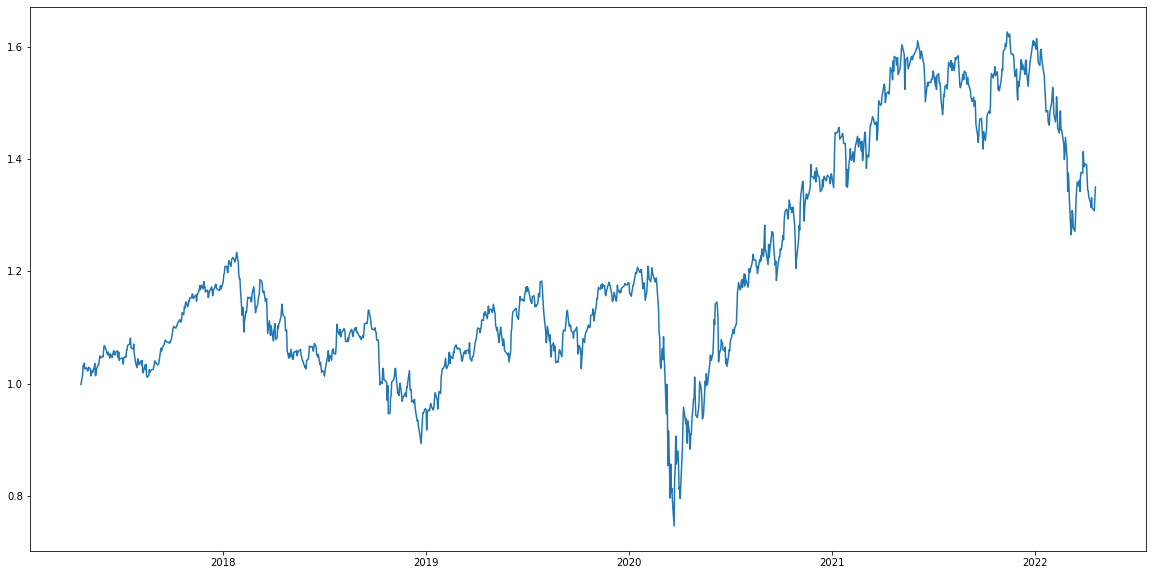

In [10]:
# visually analyzing the performance of stocks as a portfolio :
weights = equal_weights(portfolio)
portfolio_price_action = portfolio_cumulative.dot(weights)
portfolio_price_action.plot(figsize = (20,10))

In [11]:
# To compare the performance of bench mark with portfolio and visually analyzing it :
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()
comparison = comparison.rename(columns = {0:'E.W Portfolio'})

<AxesSubplot:>

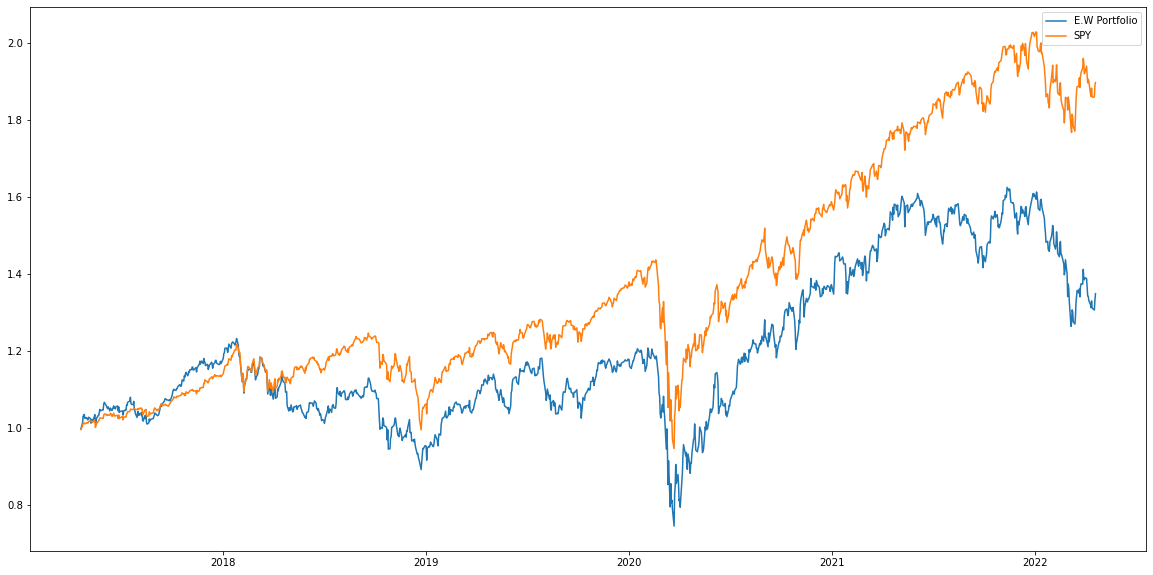

In [12]:
#Plot the comparison data
comparison.plot(figsize = (20,10))

In [13]:
#Running  Monte Carlos simulation to understand the probable returns of portfolio over 1 year:
sim_ew = MCSimulation(
    portfolio,
    weights=equal_weights(portfolio),
    num_simulation=1000,
    num_trading_days=252,
)

In [14]:
sim_ew.calc_cumulative_return()

'Running Monte Carlo simulation number 990.'

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.984472,1.015655,1.006648,0.997596,1.005105,0.999150,1.017880,1.005870,1.003526,0.997211,...,1.008460,0.991291,1.001164,1.003188,0.995199,1.016746,0.998345,1.001942,0.992707,1.003843
2,0.988329,1.017508,1.012458,0.999976,0.993680,1.010214,1.030386,0.992158,1.019295,0.989248,...,0.997973,1.000074,0.998458,1.004565,0.993523,1.024736,0.985244,1.003581,0.994130,1.018596
3,0.985201,1.014149,1.009260,1.002248,1.004257,1.013686,1.028278,1.002106,1.031109,0.990536,...,0.994331,0.997552,1.018114,1.004010,0.999595,1.026585,0.993982,0.992459,0.994863,1.004144
4,0.992062,1.001354,1.012866,1.005992,1.010559,1.002731,1.024396,0.995173,1.019045,0.988651,...,0.980208,1.002630,1.012343,1.006332,1.002916,1.019880,1.001460,0.989096,0.991294,1.000721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1.157791,1.248626,1.071888,0.960882,1.280937,0.798466,0.955628,1.168102,1.073590,1.170054,...,1.229522,1.316360,0.839764,1.361945,1.182075,1.287353,1.053806,1.332402,1.180512,0.916118
249,1.136552,1.238031,1.067697,0.968733,1.282395,0.810803,0.959014,1.167097,1.087194,1.173430,...,1.223410,1.313931,0.823693,1.365015,1.187865,1.285375,1.048438,1.332973,1.172931,0.909361
250,1.140079,1.244244,1.058261,0.966149,1.296927,0.811721,0.955646,1.168018,1.078316,1.175584,...,1.218307,1.304908,0.829389,1.377456,1.203890,1.291220,1.042231,1.346470,1.166103,0.904664
251,1.157848,1.239975,1.063221,0.970591,1.297178,0.810793,0.950076,1.167053,1.083415,1.181659,...,1.222704,1.297590,0.829721,1.377465,1.205542,1.298323,1.045392,1.326542,1.162815,0.904312


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days.'}>

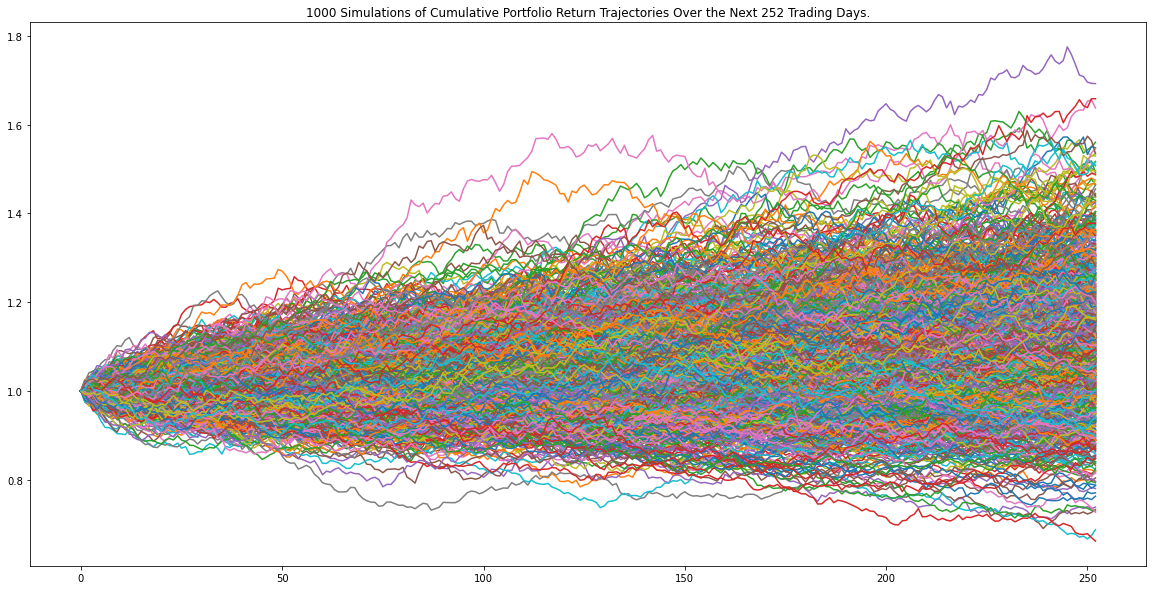

In [15]:
#  Plotting simulation:
sim_ew.plot_simulation()

In [16]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_stats = sim_ew.summarize_cumulative_return()

# Print summary statistics
print(summary_stats)

# Set initial investment
initial_investment = 1000

# Using lower & upper CI to calculate the `95%` confidence intervalsfor investment of $1000
ci_lower = round(summary_stats[8] * initial_investment, 2)
ci_upper = round(summary_stats[9] * initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
      f" over a year will end within in the range of"
      f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")
# returns in percentage :
lower_range = ((ci_lower-initial_investment)/initial_investment)*100
upper_range = ((ci_upper-initial_investment)/initial_investment)*100
print(f"95% probability of returns range : {lower_range:,.02f}% - {upper_range:,.02f}%")

count           1000.000000
mean               1.115432
std                0.153017
min                0.661489
25%                1.009947
50%                1.106819
75%                1.207006
max                1.692527
95% CI Lower       0.838883
95% CI Upper       1.441682
Name: 252, dtype: float64
There is a 95% chance that an initial investment of $1,000.00 in the portfolio over a year will end within in the range of $838.88 and $1,441.68
95% probability of returns range : -16.11% - 44.17%


In [17]:
# Determining the returns with varrying weights and retrieving the top 5:
top_returns = combination_weights(portfolio,initial_investment=1000)

In [18]:
top_returns

,Return,Weights
13442,1451.057672,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)"
13429,1447.041352,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)"
13433,1446.500336,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)"
13440,1445.982549,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)"
13436,1445.777355,"(0.13, 0.14, 0.15, 0.18, 0.19, 0.21)"


In [19]:
sharpe_ratio = sharpe_ratios(top_returns)

C:\Users\Zahra\anaconda3\envs\alpacaenv\lib\site-packages\pandas\core\indexes\base.py:334: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.inner_join_indexer(sv, ov)
C:\Users\Zahra\anaconda3\envs\alpacaenv\lib\site-packages\pandas\core\dtypes\missing.py:484: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  ensure_object(left.ravel()), ensure_object(right.ravel())


In [20]:
sharpe_ratio

,Return,Weights,sharpe_ratio
13442,1451.057672,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.788208
13429,1447.041352,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.761983
13433,1446.500336,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.773973
13440,1445.982549,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.780453
13436,1445.777355,"(0.13, 0.14, 0.15, 0.18, 0.19, 0.21)",-2.784894


In [21]:
spy_comaprison(sharpe_ratio)

,Return,Weights,sharpe_ratio,%_return
13442,1451.057672,"(0.14, 0.15, 0.16, 0.17, 0.18, 0.2)",-2.788208,45.105767
13429,1447.041352,"(0.13, 0.14, 0.15, 0.16, 0.17, 0.25)",-2.761983,44.704135
13433,1446.500336,"(0.13, 0.14, 0.15, 0.17, 0.18, 0.23)",-2.773973,44.650034
13440,1445.982549,"(0.13, 0.15, 0.16, 0.17, 0.18, 0.21)",-2.780453,44.598255
13436,1445.777355,"(0.13, 0.14, 0.15, 0.18, 0.19, 0.21)",-2.784894,44.577736
SPY,1898.359820,1.0,-3.173903,89.835982
